In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
DATASET_PATH = "/content/drive/MyDrive/Cotton Final"

IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42


In [ ]:
image_paths = []
labels = []

for class_name in os.listdir(DATASET_PATH):
    class_path = os.path.join(DATASET_PATH, class_name)

    if os.path.isdir(class_path):
        images = os.listdir(class_path)

        np.random.shuffle(images)

        images = images[:500]

        for img in images:
            image_paths.append(os.path.join(class_path, img))
            labels.append(class_name)

data_df = pd.DataFrame({
    "filename": image_paths,
    "class": labels
})

print("Total Images Used:", len(data_df))
print(data_df["class"].value_counts())


Total Images Used: 4829
class
Powdery mildew       500
Target Spot          500
Healthy              500
Green Cotton Boll    500
Bacterial Blight     500
Cotton Boll Rot      500
Army worm            500
Aphids               500
Curl Virus           418
Fussarium Wilt       411
Name: count, dtype: int64


In [ ]:
# 70% Train, 30% Temp
train_df, temp_df = train_test_split(
    data_df,
    test_size=0.30,
    stratify=data_df["class"],
    random_state=SEED
)

# Split temp → 15% Val, 15% Test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["class"],
    random_state=SEED
)

print("Train:", len(train_df))
print("Validation:", len(val_df))
print("Test:", len(test_df))


Train: 3380
Validation: 724
Test: 725


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="class",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

val_gen = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col="filename",
    y_col="class",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col="filename",
    y_col="class",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 3380 validated image filenames belonging to 10 classes.
Found 724 validated image filenames belonging to 10 classes.
Found 725 validated image filenames belonging to 10 classes.


In [ ]:
class_names = list(train_gen.class_indices.keys())
num_classes = len(class_names)

print("Classes:", class_names)


Classes: ['Aphids', 'Army worm', 'Bacterial Blight', 'Cotton Boll Rot', 'Curl Virus', 'Fussarium Wilt', 'Green Cotton Boll', 'Healthy', 'Powdery mildew', 'Target Spot']


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def build_crnn(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # -------- CNN BLOCK --------
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Reshape((28, 28 * 256))(x)

    # -------- RNN BLOCK --------
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Bidirectional(layers.LSTM(128))(x)
    x = layers.Dropout(0.3)(x)

    # -------- CLASSIFIER --------
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model

# Create the model
model = build_crnn(num_classes=num_classes)

# Compile the model with a slightly higher learning rate
optimizer = Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 28, 7168)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 28, 512)        │    15,206,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,269,578 (62.06 MB)

 Trainable params: 16,268,682 (62.06 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['class']),
    y=train_df['class']
)

class_weights = dict(enumerate(class_weights))
print(class_weights)


{0: np.float64(0.9657142857142857), 1: np.float64(0.9657142857142857), 2: np.float64(0.9657142857142857), 3: np.float64(0.9657142857142857), 4: np.float64(1.1575342465753424), 5: np.float64(1.1736111111111112), 6: np.float64(0.9657142857142857), 7: np.float64(0.9657142857142857), 8: np.float64(0.9657142857142857), 9: np.float64(0.9657142857142857)}


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        "/content/drive/MyDrive/Cotton_disease_CRNN.keras",
        save_best_only=True
    )
]


In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks,
    class_weight=class_weights
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.2309 - loss: 2.1365 

106/106 ━━━━━━━━━━━━━━━━━━━━ 2752s 26s/step - accuracy: 0.2313 - loss: 2.1355 - val_accuracy: 0.1229 - val_loss: 3.6238 - learning_rate: 0.0010
Epoch 2/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 66s 621ms/step - accuracy: 0.3740 - loss: 1.7829 - val_accuracy: 0.1285 - val_loss: 3.8710 - learning_rate: 0.0010
Epoch 3/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.4105 - loss: 1.6298

106/106 ━━━━━━━━━━━━━━━━━━━━ 68s 641ms/step - accuracy: 0.4106 - loss: 1.6296 - val_accuracy: 0.1713 - val_loss: 2.4983 - learning_rate: 0.0010
Epoch 4/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.4462 - loss: 1.5590

106/106 ━━━━━━━━━━━━━━━━━━━━ 83s 647ms/step - accuracy: 0.4464 - loss: 1.5587 - val_accuracy: 0.3163 - val_loss: 2.1522 - learning_rate: 0.0010
Epoch 5/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.4817 - loss: 1.4751

106/106 ━━━━━━━━━━━━━━━━━━━━ 74s 695ms/step - accuracy: 0.4819 - loss: 1.4748 - val_accuracy: 0.5539 - val_loss: 1.3416 - learning_rate: 0.0010
Epoch 6/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.5239 - loss: 1.3777

106/106 ━━━━━━━━━━━━━━━━━━━━ 74s 701ms/step - accuracy: 0.5237 - loss: 1.3778 - val_accuracy: 0.6008 - val_loss: 1.1900 - learning_rate: 0.0010
Epoch 7/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 72s 678ms/step - accuracy: 0.5438 - loss: 1.3316 - val_accuracy: 0.4061 - val_loss: 1.8419 - learning_rate: 0.0010
Epoch 8/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.5608 - loss: 1.2716

106/106 ━━━━━━━━━━━━━━━━━━━━ 71s 672ms/step - accuracy: 0.5607 - loss: 1.2717 - val_accuracy: 0.5843 - val_loss: 1.1709 - learning_rate: 0.0010
Epoch 9/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 71s 673ms/step - accuracy: 0.5551 - loss: 1.2634 - val_accuracy: 0.3688 - val_loss: 2.2522 - learning_rate: 0.0010
Epoch 10/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 66s 622ms/step - accuracy: 0.5804 - loss: 1.2070 - val_accuracy: 0.5401 - val_loss: 1.2924 - learning_rate: 0.0010
Epoch 11/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.6133 - loss: 1.1282
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
106/106 ━━━━━━━━━━━━━━━━━━━━ 65s 614ms/step - accuracy: 0.6131 - loss: 1.1285 - val_accuracy: 0.4323 - val_loss: 1.8488 - learning_rate: 0.0010
Epoch 12/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.6269 - loss: 1.0793

106/106 ━━━━━━━━━━━━━━━━━━━━ 69s 655ms/step - accuracy: 0.6271 - loss: 1.0786 - val_accuracy: 0.6961 - val_loss: 0.8711 - learning_rate: 3.0000e-04
Epoch 13/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 71s 665ms/step - accuracy: 0.6810 - loss: 0.9132 - val_accuracy: 0.6699 - val_loss: 0.9218 - learning_rate: 3.0000e-04
Epoch 14/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.6833 - loss: 0.8878

106/106 ━━━━━━━━━━━━━━━━━━━━ 68s 643ms/step - accuracy: 0.6832 - loss: 0.8879 - val_accuracy: 0.7334 - val_loss: 0.8244 - learning_rate: 3.0000e-04
Epoch 15/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.6985 - loss: 0.8287

106/106 ━━━━━━━━━━━━━━━━━━━━ 74s 689ms/step - accuracy: 0.6985 - loss: 0.8288 - val_accuracy: 0.7251 - val_loss: 0.7882 - learning_rate: 3.0000e-04
Epoch 16/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.7228 - loss: 0.8068

106/106 ━━━━━━━━━━━━━━━━━━━━ 75s 700ms/step - accuracy: 0.7228 - loss: 0.8069 - val_accuracy: 0.7417 - val_loss: 0.7873 - learning_rate: 3.0000e-04
Epoch 17/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 71s 670ms/step - accuracy: 0.7357 - loss: 0.7758 - val_accuracy: 0.6892 - val_loss: 0.9072 - learning_rate: 3.0000e-04
Epoch 18/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.7199 - loss: 0.7935

106/106 ━━━━━━━━━━━━━━━━━━━━ 69s 643ms/step - accuracy: 0.7200 - loss: 0.7934 - val_accuracy: 0.7445 - val_loss: 0.7505 - learning_rate: 3.0000e-04
Epoch 19/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 71s 665ms/step - accuracy: 0.7538 - loss: 0.7016 - val_accuracy: 0.7417 - val_loss: 0.7720 - learning_rate: 3.0000e-04
Epoch 20/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 65s 617ms/step - accuracy: 0.7623 - loss: 0.7032 - val_accuracy: 0.6740 - val_loss: 1.0332 - learning_rate: 3.0000e-04
Epoch 21/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.7598 - loss: 0.7202
Epoch 21: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
106/106 ━━━━━━━━━━━━━━━━━━━━ 65s 616ms/step - accuracy: 0.7598 - loss: 0.7203 - val_accuracy: 0.7555 - val_loss: 0.7582 - learning_rate: 3.0000e-04
Epoch 22/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.7692 - loss: 0.6631

106/106 ━━━━━━━━━━━━━━━━━━━━ 69s 644ms/step - accuracy: 0.7692 - loss: 0.6628 - val_accuracy: 0.7790 - val_loss: 0.6375 - learning_rate: 9.0000e-05
Epoch 23/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 70s 659ms/step - accuracy: 0.7859 - loss: 0.6545 - val_accuracy: 0.7666 - val_loss: 0.7383 - learning_rate: 9.0000e-05
Epoch 24/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.8073 - loss: 0.5756

106/106 ━━━━━━━━━━━━━━━━━━━━ 69s 648ms/step - accuracy: 0.8073 - loss: 0.5758 - val_accuracy: 0.8011 - val_loss: 0.6223 - learning_rate: 9.0000e-05
Epoch 25/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 72s 681ms/step - accuracy: 0.8224 - loss: 0.5620 - val_accuracy: 0.7776 - val_loss: 0.6829 - learning_rate: 9.0000e-05
Epoch 26/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 76s 629ms/step - accuracy: 0.7938 - loss: 0.5866 - val_accuracy: 0.7804 - val_loss: 0.6600 - learning_rate: 9.0000e-05
Epoch 27/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.8144 - loss: 0.5539
Epoch 27: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
106/106 ━━━━━━━━━━━━━━━━━━━━ 66s 625ms/step - accuracy: 0.8143 - loss: 0.5540 - val_accuracy: 0.7970 - val_loss: 0.6335 - learning_rate: 9.0000e-05
Epoch 28/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 66s 623ms/step - accuracy: 0.8100 - loss: 0.5511 - val_accuracy: 0.7818 - val_loss: 0.6441 - learning_rate: 2.7000e-05
Epoch 29/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - a

106/106 ━━━━━━━━━━━━━━━━━━━━ 69s 650ms/step - accuracy: 0.8057 - loss: 0.5753 - val_accuracy: 0.8080 - val_loss: 0.5858 - learning_rate: 2.7000e-05
Epoch 30/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 71s 661ms/step - accuracy: 0.8123 - loss: 0.5705 - val_accuracy: 0.8080 - val_loss: 0.5887 - learning_rate: 2.7000e-05


In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_gen)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

23/23 ━━━━━━━━━━━━━━━━━━━━ 439s 20s/step - accuracy: 0.8643 - loss: 0.4520
Test Loss: 0.466327041387558
Test Accuracy: 0.8468965291976929


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step


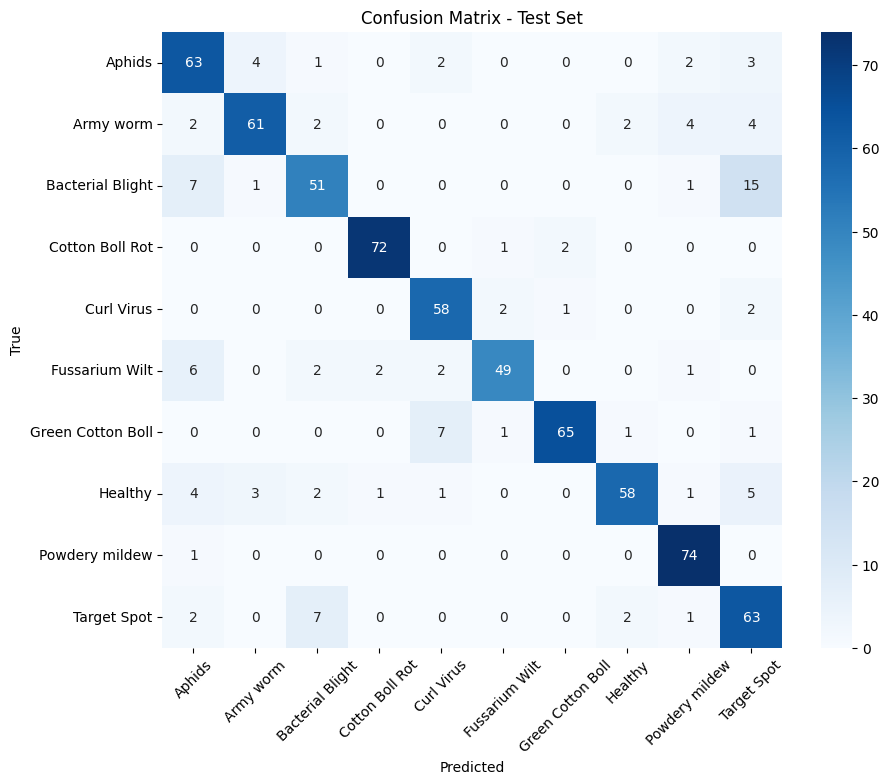

In [ ]:
test_gen.reset()
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.xticks(rotation=45)
plt.show()


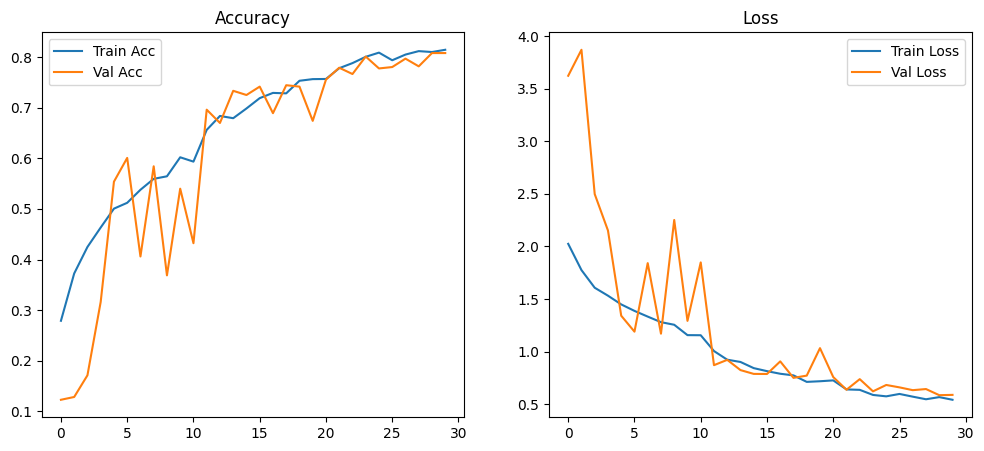

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()


In [ ]:
report = classification_report(
    y_true,
    y_pred,
    target_names=class_names
)

print("Classification Report:\n")
print(report)


Classification Report:

                   precision    recall  f1-score   support

           Aphids       0.74      0.84      0.79        75
        Army worm       0.88      0.81      0.85        75
 Bacterial Blight       0.78      0.68      0.73        75
  Cotton Boll Rot       0.96      0.96      0.96        75
       Curl Virus       0.83      0.92      0.87        63
   Fussarium Wilt       0.92      0.79      0.85        62
Green Cotton Boll       0.96      0.87      0.91        75
          Healthy       0.92      0.77      0.84        75
   Powdery mildew       0.88      0.99      0.93        75
      Target Spot       0.68      0.84      0.75        75

         accuracy                           0.85       725
        macro avg       0.86      0.85      0.85       725
     weighted avg       0.86      0.85      0.85       725



In [ ]:
model.save("/content/drive/MyDrive/Cotton_disease_CRNN.keras")
print("Model Saved Successfully!")

Model Saved Successfully!
